In [1]:
import numpy as np 
import open3d as o3d
import os
from natsort import natsorted
from glob import glob
from upsampling_mesh import meshify
from sklearn.neighbors import NearestNeighbors
import pdb 

o3d.utility.set_verbosity_level(o3d.utility.VerbosityLevel.Error)

def find_neighs(points, k=2):
    nbrs = NearestNeighbors(n_neighbors=k, algorithm= 'kd_tree').fit(points)
    distances, indices = nbrs.kneighbors(points) #cross checked, gives the 12 norm of the difference betweent he pair of points considered
    # print(type(distances), type(indices), distances.shape, indices.shape) # they are numpy arraysand the sizes are same: 2048, num_of_neighs
    # distances = np.sum(distances, axis=1)
    # r = np.mean(distances)
    return distances, indices

def patching(points, normals, radius_chosen):
    distances, indices = find_neighs(points, k=2)


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:

paths = natsorted(glob('ShapeNetCorev2/*/*/models/*.obj'))
meshes= meshify(paths)
pcd_list = np.array([mesh[0] for mesh in meshes])
normals_list = np.array([mesh[1] for mesh in meshes])
print(pcd_list.shape, normals_list.shape)

in meshify
ShapeNetCorev2/03001627/1ad766f9e95ce308aa425ecb668e59de/models/model_normalized.obj  skipped
ShapeNetCorev2/03001627/1b5ab441fb8e3b1b450621b513a975bb/models/model_normalized.obj  skipped
ShapeNetCorev2/03001627/1b8e84935fdc3ec82be289de70e8db31/models/model_normalized.obj  skipped
ShapeNetCorev2/03001627/1b05971a4373c7d2463600025db2266/models/model_normalized.obj  skipped
ShapeNetCorev2/03001627/1c2caacac14dfa0019fb4103277a6b93/models/model_normalized.obj  skipped
ShapeNetCorev2/03001627/1c5d66f3e7352cbf310af74324aae27f/models/model_normalized.obj  skipped
ShapeNetCorev2/03001627/1c17cc67b8c747c3febad4f49b26ec52/models/model_normalized.obj  skipped
ShapeNetCorev2/03001627/1cd152cfd71cd314e2798a633e84d70b/models/model_normalized.obj  skipped
ShapeNetCorev2/03001627/1d1b37ce6d72d7855096c0dd2594842a/models/model_normalized.obj  skipped
ShapeNetCorev2/03001627/1d1c829a54f0ae426cdb122727dd360f/models/model_normalized.obj  skipped
ShapeNetCorev2/03001627/1d8d16c0750f22f5ece93f2bb0

In [4]:
np.save('pcd_list2.npy', pcd_list)
np.save('normals_list2.npy', normals_list) 

In [ ]:
for pcd, normals in zip(pcd_list, normals_list):
    r, no_neigh = patching(pcd, normals, radius_chosen=0.5)
    if no_neigh:
        print("no neighbors found for a point for radius: ", 0.5)

In [289]:
pcd_list.shape

(16867, 2048, 3)

In [194]:
dists_ori, indices_ori = find_neighs(pcd_list[10], k=20)
dists_ori = dists_ori[:, 1:]
indices_ori = indices_ori[:, 1:]

<class 'numpy.ndarray'> <class 'numpy.ndarray'> (2048, 20) (2048, 20)


In [180]:
# ind = np.argwhere(dists_ori == 0.0)
# dists_ori = np.delete(dists_ori, ind)
# indices_ori = np.delete(indices_ori, ind)
# print(dists_ori.shape, indices_ori.shape)
# print(np.argwhere(dists_ori == 0.0))

(38912,) (38912,)
[[   12]
 [   32]
 [   52]
 ...
 [38852]
 [38872]
 [38892]]


In [183]:
# print(np.argwhere(dists_ori == 0.0).shape)
# # dists_ori[12]

(1945, 1)


In [199]:
chk = np.array([[1,2],[1,2],[1,2]])
sum = np.apply_along_axis(np.sum, 0, chk)
print(sum)

[3 6]


In [211]:
labels

array([<ckwrap.result.CkwrapResult object at 0x7f7d8c2ec4f0>,
       <ckwrap.result.CkwrapResult object at 0x7f7d8c2f5460>, ...,
      dtype=object)

In [206]:
import numpy as np
import ckwrap

# Apply ckmeans to all rows and extract labels using a lambda function:
labels_per_row = np.apply_along_axis(lambda row: ckwrap.ckmeans(row, 5).labels, 1, dists_ori)

print(labels_per_row)  # Now displays the actual labels for each row


[[0 0 0 ... 3 4 4]
 [0 0 0 ... 4 4 4]
 [0 1 1 ... 4 4 4]
 ...
 [0 0 0 ... 4 4 4]
 [0 0 1 ... 3 4 4]
 [0 0 1 ... 3 4 4]]


In [210]:
labels_per_row.shape

(2048, 19)

In [218]:
print(dists_ori[0], labels_per_row[0])

[0.00505384 0.00771389 0.00843185 0.00914333 0.01061711 0.01196387
 0.01288032 0.01293064 0.0181089  0.01844704 0.01869763 0.01894341
 0.01968787 0.02051718 0.0212329  0.02126844 0.02159118 0.02369304
 0.02408181] [0 0 0 0 1 1 1 1 2 2 2 2 2 3 3 3 3 4 4]


In [231]:
indices_ori[0].shape

(19,)

In [234]:
indices_ori[0][np.where(labels_per_row[0] == 1)[0]]

array([1213, 1446,  331,  981])

In [269]:
'''
dists_array has 5 lists within, each list represents a cluster and has 2048 elements.
'''

dists_arrays = [[] for _ in np.unique(labels_per_row[0])]
indices_arrays = [[]for _ in np.unique(labels_per_row[0])]
for dist, ind, labels in zip(dists_ori, indices_ori, labels_per_row):
    # dist, ind, labels of shapes: (19,)
    for i in  np.unique(labels):
        temp_i = ind[np.where(labels == i)[0]]
        temp_d = dist[np.where(labels == i)[0]]
        dists_arrays[i].append(np.array([temp_d], dtype=object))
        indices_arrays[i].append(np.array([temp_i], dtype=object))


In [288]:
dists_arrays[0][5]

array([[0.009790828770921413, 0.010301353170411573, 0.010544608769868387,
        0.011096427799126098]], dtype=object)

In [285]:
for i in np.unique(labels_per_row[0]):
    print(dists_arrays[i][0].shape)

(1, 4)
(1, 4)
(1, 5)
(1, 4)
(1, 2)


In [264]:
# dists_arrays = [np.array([]) for _ in np.unique(labels_per_row[0])]
# indices_arrays = [np.array([]) for _ in np.unique(labels_per_row[0])]
# for dist, ind, labels in zip(dists_ori, indices_ori, labels_per_row):
#     for i in  np.unique(labels_per_row[0]):
#         indices_arrays[i] = ind[np.where(labels == i)[0]]
#         dists_arrays[i] = dist[np.where(labels == i)[0]]  
# dists_arrays = np.array(dists_arrays, dtype=object)
# indices_arrays = np.array(indices_arrays, dtype = object)
# print(dists_arrays)

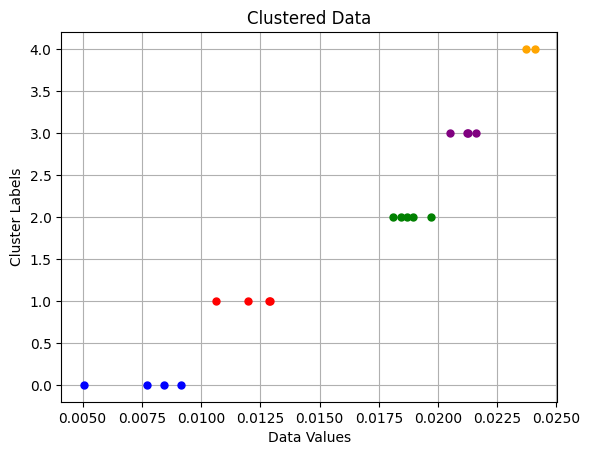

In [283]:
#visualising the clusters

import matplotlib.pyplot as plt
fig, ax = plt.subplots() 
colors = ['blue', 'red', 'green', 'purple', 'orange']  
for i, bucket in enumerate(dists_arrays):
    ax.plot(bucket[0], [i] * len(bucket[0]), '.', color=colors[i], markersize=10)

plt.xlabel("Data Values")
plt.ylabel("Cluster Labels")
plt.title("Clustered Data")
plt.grid(True) 
plt.show()


In [195]:
import ckwrap

nums= np.array(dists_ori[0])
km = ckwrap.ckmeans(nums,5)
labels = np.array(km.labels)
print(labels)

# buckets = [[],[],[], [], []]
# for i in range(len(nums)):
#     buckets[km.labels[i]].append(nums[i])
# print(buckets)

# dists_arrays = [np.array([]) for _ in np.unique(labels)]
# indices_arrays = [np.array([]) for _ in np.unique(labels)]
# for i in  np.unique(labels):
#     indices_arrays[i] = indices_ori[np.where(labels == i)[0]]
#     dists_arrays[i] = dists_ori[np.where(labels == i)[0]]    

# # indices = np.empty((0,), dtype = object)
# # dists = np.empty((0,), dtype = object)
# # for i in range(5):
# #     indices = np.append(indices, indices_ori[0][np.where(labels==i)[0]])
# #     dists = np.append(dists, dists_ori[0][np.where(labels==i)[0]])
# indices_arrays = np.array(indices_arrays, dtype=object)
# dists_arrays = np.array(dists_arrays, dtype=object)
# print(dists_arrays.shape, indices_arrays.shape)


[0 0 0 0 1 1 1 1 2 2 2 2 2 3 3 3 3 4 4]


[array([0.00505384, 0.00771389, 0.00843185, 0.00914333]), array([0.01061711, 0.01196387, 0.01288032, 0.01293064]), array([0.0181089 , 0.01844704, 0.01869763, 0.01894341, 0.01968787]), array([0.02051718, 0.0212329 , 0.02126844, 0.02159118]), array([0.02369304, 0.02408181])]


In [175]:
#min max of each in bucket
for i in range(5):
    print(min(buckets[i]), max(buckets[i]))

0.0 0.0
0.005053836889737338 0.009143333146522664
0.01061711274637709 0.012930643141806981
0.01810890279300383 0.020517184649540672
0.021232895883427156 0.024081811572722767


In [197]:
for i in np.unique(labels):
    print('cluster: ', i)
    print(dists_arrays[i])
    print("min: ", np.min(dists_arrays[i]))
    print("max: ", np.max(dists_arrays[i]))

cluster:  0
[0.00505384 0.00771389 0.00843185 0.00914333]
min:  0.005053836889737338
max:  0.009143333146522664
cluster:  1
[0.01061711 0.01196387 0.01288032 0.01293064]
min:  0.01061711274637709
max:  0.012930643141806981
cluster:  2
[0.0181089  0.01844704 0.01869763 0.01894341 0.01968787]
min:  0.01810890279300383
max:  0.019687866252756845
cluster:  3
[0.02051718 0.0212329  0.02126844 0.02159118]
min:  0.020517184649540672
max:  0.021591175679069374
cluster:  4
[0.02369304 0.02408181]
min:  0.023693036622454935
max:  0.024081811572722767


In [108]:
a= np.array([1,2,3,4,5,6,7,8,9,10])
b = np.array(['hbd', 'hny'])
# c= [a,b]
print(a.shape)
c= np.array([a, b], dtype=object)
print(c.shape, c[0].shape, c[1].shape)

(10,)
(2,) (10,) (2,)


In [41]:
buckets[0]

[0.012880320129820304,
 0.021232895883427156,
 0.011963866972353378,
 0.018447037028806512,
 0.009143333146522664,
 0.01810890279300383,
 0.0,
 0.007713890821604149,
 0.005053836889737338,
 0.008431851265898595,
 0.018943411427799813,
 0.019687866252756845,
 0.01061711274637709,
 0.0186976279084326,
 0.02126844136530484,
 0.024081811572722767,
 0.024765546835199093,
 0.021591175679069374,
 0.020517184649540672,
 0.012930643141806981,
 0.023693036622454935]

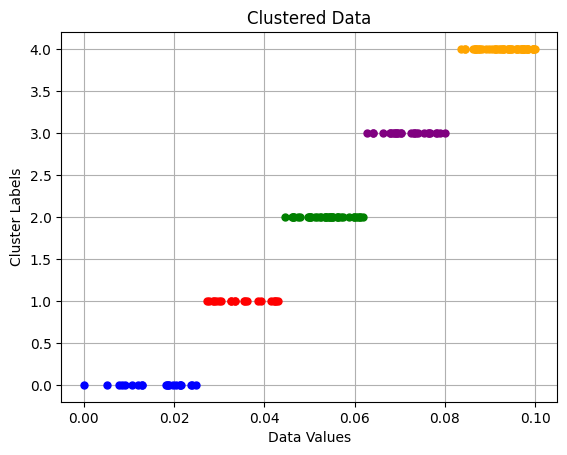

In [38]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots() 
colors = ['blue', 'red', 'green', 'purple', 'orange']  
for i, bucket in enumerate(buckets):
    ax.plot(bucket, [i] * len(bucket), '.', color=colors[i], markersize=10)

plt.xlabel("Data Values")
plt.ylabel("Cluster Labels")
plt.title("Clustered Data")
plt.grid(True)
plt.show()


In [10]:
#visualize pcd
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pcd_list[10])
pcd.normals = o3d.utility.Vector3dVector(normals_list[10])
o3d.visualization.draw_geometries([pcd])
